In [6]:
# 2025-07-17 simulates and fits the full noise model, including mixture model for outliers, and a 
# three-coefficient dependence of noise major axis on apparent magnitude.
#
# This example runs on data we generated in an earlier run. The input truth file is blank, we will use
# this to find any areas where the simulator still depends on truths.
#
# test usage of npts input (to override parameter file for convenience, e.g. if that's all we're changing)

Comment: it's generally better NOT to run-all, but to run down to the first "examine2d.showguess" call, then CHECK whether the fit is giving sensible results.

# Import modules and determine a couple of arguments for this run

In [7]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pylab as plt
plt.ion()
from importlib import reload
import emcee
import time
import mcmc2d
import examine2d
import apply2d
import pickle

In [8]:
%matplotlib inline

In [9]:
# some strings we can change programmatically
npoints_arg = 40  # if simulating, change the number of stars. This appears in output filenames.
styp='fullnoise2'

## Do initial fit, set up for MCMC, and do any nonparametric bootstraps.

In [13]:
# param file now has c not log10(c). The acceptance fraction is quite low, so we rerun this with 6x the length.
#
# Note that any non-parametric bootstrapping happens in this step, so this can take a while to run if that
# is enabled.
reload(mcmc2d)
esargs, runargs, showargs = mcmc2d.setupmcmc(pathconfig='mcmc_notruth_pars.ini')

MCMCrun.loadconfig INFO - reading configuration from mcmc_notruth_pars.ini
Reading truth parset from 
MCMCrun.loadtruths WARN - truth path not readable: 
MCMCrun.loadtruths WARN - setting self.ignoretruth to True
setupmcmc INFO - MC parfile_guess: eg11_guess_mix_fullnoise2.ini
Guess.loadconfig WARN - parse problems with keywords: ['alpha0', 'delta0']
mcmc2d.doguess DEBUG: guess transf: []
mcmc2d.doguess DEBUG - initialized guess parset:
[0. 0. 0. 0. 0. 0.]
[-6. -6.  2.]
[0.9 0.1]
[ -1.1 -10. ]
Guess degree: 1
mcmc2d.doguess DEBUG =======
PROPAG COVAR DEBUG:
[[ 1.18409608e-12 -6.12825348e-15]
 [-6.12825348e-15  3.23846955e-13]]
[[4.47772538e-13 2.68663523e-14]
 [2.68663523e-14 1.61198114e-13]]
fit2d.Guess.updatelsq_covars INFO - re-fitting the lsq with propagated covars
fit2d.Guess.updatelsq_covars INFO - before and after:
[[[ 2.25583510e+12 -3.75972517e+11]
  [-3.75972517e+11  6.26620862e+12]]

 [[ 1.38895148e+12 -2.31491913e+11]
  [-2.31491913e+11  3.85819854e+12]]]
[[[ 6.13127564e+11

showguess DEBUG - bbg: 3


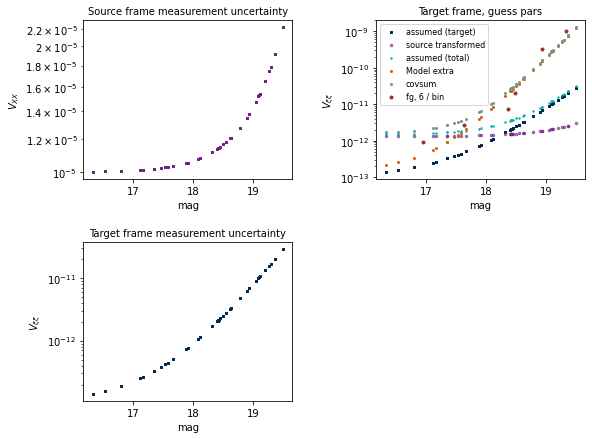

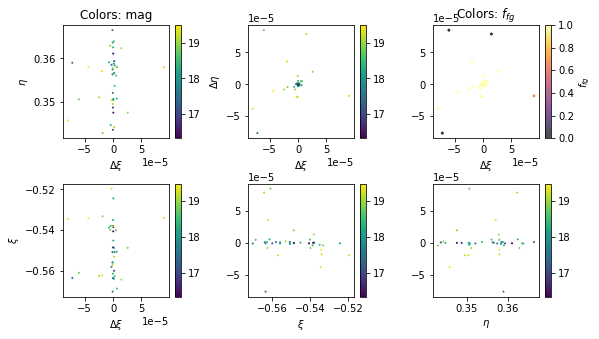

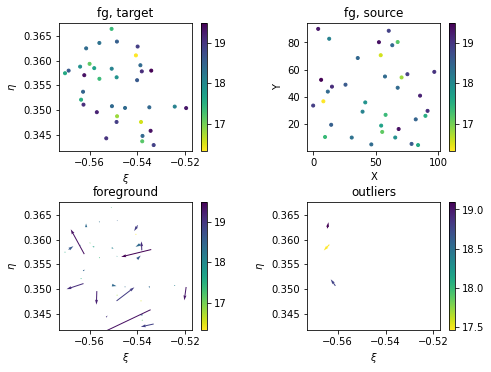

In [14]:
examine2d.showguess(esargs, nmagbins=6, showargs=showargs)

In [ ]:
#esargs['args'][0].parsx

In [ ]:
# local changes to showguess
# runargs.keys()

# Run the MCMC sampler and put the results into a "Flatsamples" object

In [15]:
# OK so plots appear to work. Now try the sampling!
with Pool() as pool:
    sampler = emcee.EnsembleSampler(**esargs, pool=pool)
    sampler.run_mcmc(**runargs)
    flat_samples, lnprobs = mcmc2d.getflatsamples(sampler, \
                                                  pathflat='eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                                                 pathprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp))

100%|██████████| 80000/80000 [26:08<00:00, 51.01it/s]


mcmc2d.getflatsamples INFO - measuring autocorrelation time:
mcmc2d.getflatsamples INFO - max autocorr time: 3.03e+02
mcmc2d.getflatsamples INFO - mean acceptance fraction: 0.33236026785714295 (28,) 0.3267875 0.3368
mcmc2d.getflatsamples INFO - retaining samples with finite lnprob 13692 13692
mcmc2d.getflatsamples INFO - flat samples shape: (13692, 13)


In [18]:
# bring the flat sample extraction out of the multiprocessor pool. This is particularly useful when
# testing how this works if we don't actually know the truth values...
FS = examine2d.Flatsamples(flat_samples, esargs=esargs, log_probs=lnprobs, showargs=showargs)
FS.computeresps()
FS.computesamplescovars()

examine2d.computeresps INFO - starting responsibility loop...
examine2d.computeresps INFO - iteration 13000 of 13692 after 1.53e+01 seconds: 852.0 it/sec. Est 8.12e-01 sec remain
examine2d.computeresps INFO - loops took 1.61e+01 seconds for 1.37e+04 samples
examine2d.writeresps INFO - writing responsibilities: (13692, 40)
computesamplescovars INFO - covs shape: (13692, 40, 2, 2)
computesamplescovars INFO - iteration 13000 of 13692 after 1.28e+01 seconds: 1017.4 it/sec. Est 6.80e-01 sec remain
computesamplescovars INFO - computing percentiles...
computesamplescovars INFO - ... done: (5, 40, 2, 2)


In [16]:
# so that the changes take...
import sixterm2d
reload(examine2d)

<module 'examine2d' from '/Users/wiclarks/Projects/random-prototypes/python/examine2d.py'>

examine2d.showcorner INFO - plotting corner plot...
examine2d.showcorner INFO - highlighting nuisance parameters


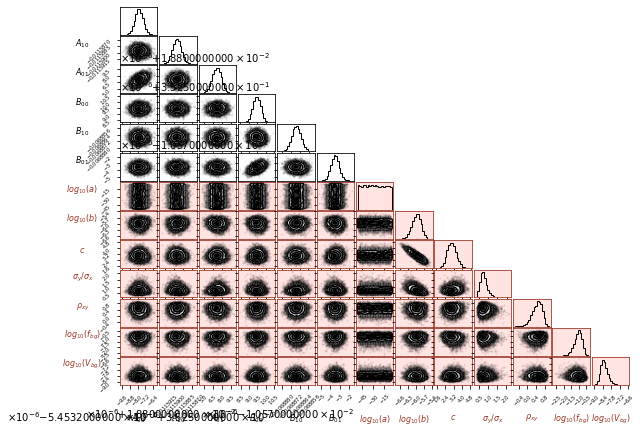

In [17]:
# ditto for showcorner. I think this actually may be where stuff may break.
examine2d.showcorner(flat_samples, **showargs['corner'], pathfig='eg11_twoframe_corner_n%i_%s.png' % (npoints_arg, styp))

In [ ]:
# write the "results" and the whole sampler to disk
FS.savepars('test_parset_medians.pickle')
with open('test_sampler.pickle','wb') as wobj:
    pickle.dump(sampler, wobj)

# Interrogate the results using the flat samples

In [39]:
# try computing something simple as the "truths" array
medians = np.quantile(flat_samples[bmain],0.5,axis=0)
print(showargs['corner']['truths'])

None


In [42]:
# uncomment one of these to fake medians as truths
showargs['corner']['truths'] = np.copy(medians)
showargs['corner']['truths'] = None

examine2d.showcorner INFO - plotting corner plot...
examine2d.showcorner INFO - highlighting nuisance parameters


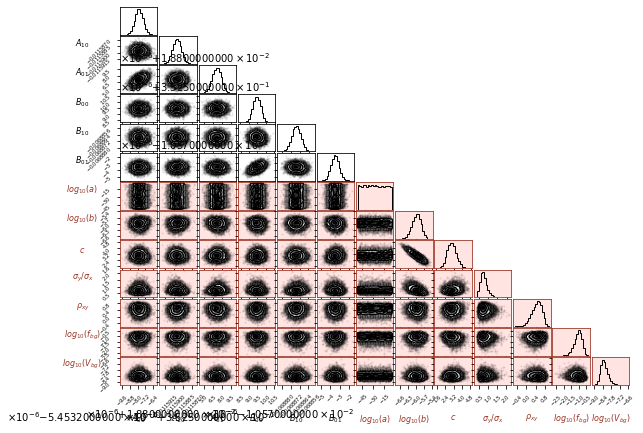

In [43]:
# Now try doing a corner-plot of only the "main" blob:
bmain = FS.ismain
examine2d.showcorner(flat_samples[bmain], **showargs['corner'], \
                     pathfig='eg11_twoframe_corner_mainclust_n%i_%s.png' % (npoints_arg, styp))

In [ ]:
print(np.sum(bmain), np.size(bmain))

In [20]:
# Compare covariance to lstsq
examine2d.showcovarscomp(FS)

showcovarscomp WARN - key not in dictionary: covpars


In [22]:
# some filename carpentry (save effort re-typing)
#
# It would be nice to have these paths output within the methods above, and/or
# set an output subdirectory to keep things compartmentalized
pathpset = 'eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp)
pathpguess = 'eg11_test_parset_guess_n%i_%s.txt' % (npoints_arg, styp)
pathsrc = 'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp)
pathtarg = 'eg11_test_obs_targ_n%i_%s.dat' % (npoints_arg, styp)

pathshowargs = 'eg11_n%i_%s_test_showargs.pickle' % (npoints_arg, styp)
pathrunargs = 'eg11_n%i_%s_test_runargs.pickle' % (npoints_arg, styp)
pathesargs = 'eg11_n%i_%s_test_esargs.pickle' % (npoints_arg, styp)

if os.access('test_parset_truth.txt', os.R_OK):
    os.rename('test_parset_truth.txt',pathpset)
os.rename('test_parset_guess.txt',pathpguess)
os.rename('test_obs_src.dat', pathsrc)
os.rename('test_obs_targ.dat', pathtarg)

os.rename('test_showargs.pickle', pathshowargs)
os.rename('test_runargs.pickle', pathrunargs)
os.rename('test_esargs.pickle', pathesargs)

In [ ]:
# copy some files across in order for the following to play nice
#!cp -p test_parset_truth.txt eg10_test_parset_truth_n300_fullnoise.txt
#!cp -p test_parset_guess.txt eg10_test_parset_guess_n300_fullnoise.txt
#!cp -p test_obs_src.dat eg10_test_obs_src_n300_fullnoise.dat

#!cp -p test_showargs.pickle eg10_fullnoise_test_showargs.pickle
#!cp -p test_runargs.pickle eg10_fullnoise_test_runargs.pickle
#!cp -p test_esargs.pickle eg10_fullnoise_test_esargs.pickle

In [23]:
fsfile='eg11_n%i_%s_flatsamples.pickle' % (npoints_arg, styp)
pickle.dump(FS, open(fsfile, 'wb'))

eg11_test_parset_guess_n40_fullnoise2.txt Poly
[0 1 2 3 4 5]
traceplot DBG: (13692, 13) (13692,)
eg11_mix_twoframe_flatsamples_n40_fullnoise2.npy
eg11_mix_twoframe_lnprobs_n40_fullnoise2.npy
DBG: grid line IDs:
300
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
samples_z DEBUG: (1000, 300) (13692,)
300000
(1000, 300)


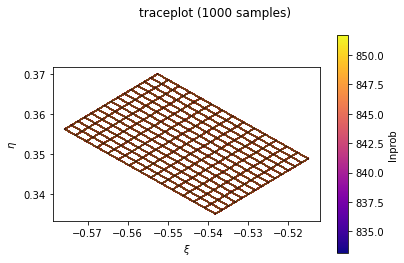

In [25]:
# apply local changes
reload(apply2d)

# For traceplot the parset doesn't need to be the truth set. Use the guess.


# Try a traceplot - may be hard to see the range for this example...
apply2d.traceplot(1000,pathpguess,\
                  'eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                 pathlnprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp), \
                 scmap='plasma')
#plt.gca().set_xlim(-0.55,-0.545)
#plt.gca().set_ylim(0.350,0.355)

In [ ]:
# apply some changes made locally between runs
reload(apply2d)

eg11_test_parset_guess_n40_fullnoise2.txt Poly
sample_uncty INFO - starting 2.50e+03 flat samples...
sample_uncty INFO - ... done in 2.14e+00 seconds
sample_uncty INFO - starting 2.50e+03 MC samples...
sample_uncty INFO - ... done in 1.41e+00 seconds
(40,) (40,) (40,)


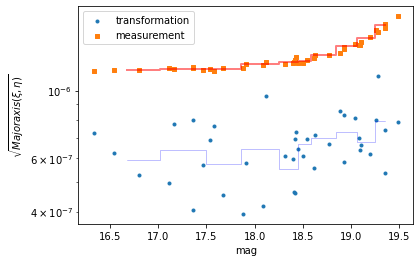

In [26]:
# Compare transformation uncertainty with pointing uncertainty
apply2d.eval_uncty(2500,'eg11_test_parset_guess_n%i_%s.txt' % (npoints_arg, styp), \
                   'eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp),\
                   'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp), nbins=10)

dxyproj_truthpars: (0,)


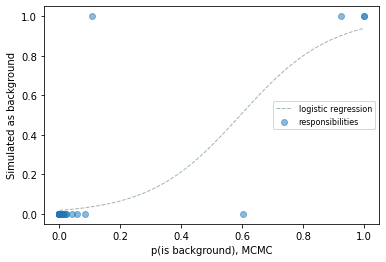

In [27]:
# incorporate local edits
# reload(examine2d)

# Since this was a mixture model, show the responsibilities
examine2d.showresps(FS)

showparsamples DEBUG: [1 2 3 5 4 6] 6 6


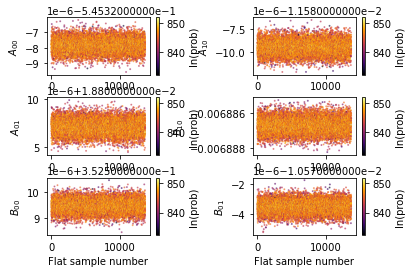

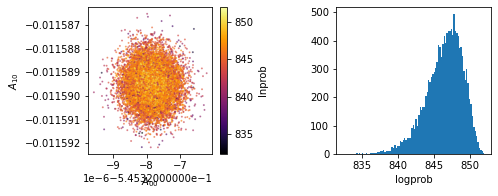

In [28]:
examine2d.showparsamples(FS)

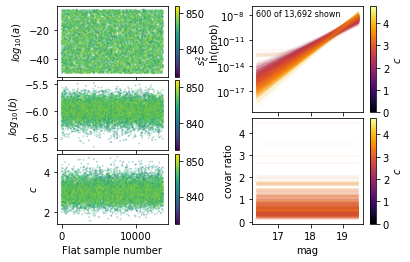

In [29]:
# shownoisesamples only makes sense if noise vs mag...
examine2d.shownoisesamples(FS, nshow=600, alpha=0.08, cmap='inferno', jaux=2)

loadparsamples INFO: pathpset eg11_test_parset_guess_n40_fullnoise2.txt, transfname:Poly
sample_transf INFO - running samples...
sample_transf INFO - ... done.
[ 0  1 15  3] [1. 1. 0. 1.]


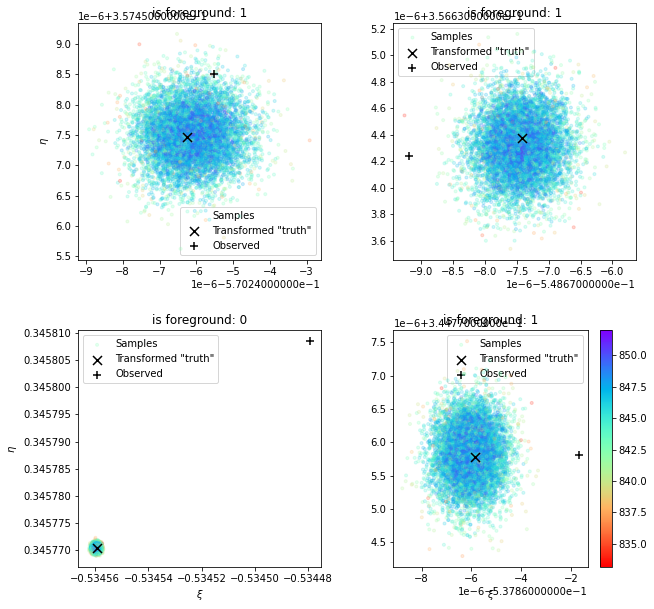

In [48]:
reload(apply2d)

# Note: the sample_transf should work if pathpset is NOT the truth values (let's try the guess, which
# should be the output of the minimizer), but the meaning will differ. See if it works:

# NOTICE: if you have the truth parameters, you probably want to set pathpset=pathpset

apply2d.sample_transf(8000, pathpset=pathpguess, \
                      pathflat='eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                      pathobs='eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp), \
                 pathlnprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp), alpha=0.2,\
                     pathtarg='eg11_test_obs_targ_n%i_%s.dat' % (npoints_arg, styp))

showunctysamples INFO - mags, pctiles, levels: (40,) (5,) (5, 40, 2, 2)


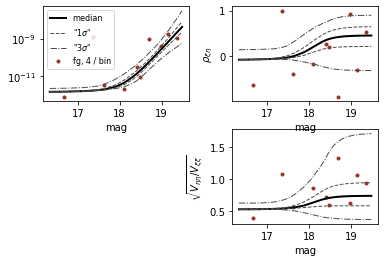

In [30]:
# how do those uncertainty bins look as percentiles?
examine2d.showunctysamples(FS)

loadparsamples INFO: pathpset eg11_test_parset_guess_n40_fullnoise2.txt, transfname:Poly
unctysamples INFO - transformation name: Poly
unctysamples INFO - starting 5.00e+03 MC samples...
... done in 2.29e+00 seconds
Computing moments...

... done in 1.87e-02 seconds.
(40, 2)
(40, 2)
(40, 2, 2)
(0,)
Offset INFO - median offset: [ 3.24925642e-11 -1.06680473e-09]
lsq pars: [ 5.71864281e-08  9.99999905e-01 -3.06325325e-07 -2.00815122e-07
  9.48086591e-09  1.00000058e+00]
lsq geom: [ 5.71864281e-08 -2.00815122e-07  9.99999905e-01  1.00000058e+00
 -9.04717584e-06 -1.70079244e-05]
===== Transformed covariances =====
Covariances of propagated positions:
majors computed: [1.35970905e-12 1.47793475e-12 1.44355009e-12 1.58261249e-12]
minors computed: [3.83988364e-13 3.94540469e-13 3.77403203e-13 4.32326168e-13]
posans computed: [-3.91490499 -3.50372208 -4.28628021 -3.97497995]
Propagated covariances of input positions
majors propag: [1.39718239e-12 1.42708267e-12 1.37599957e-12 1.55455287e-12]
mi

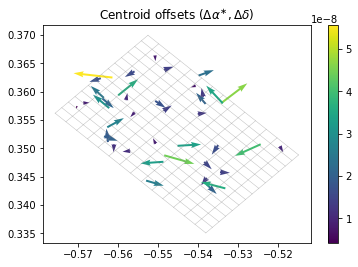

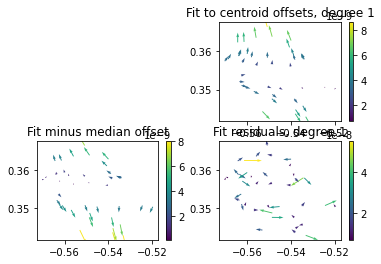

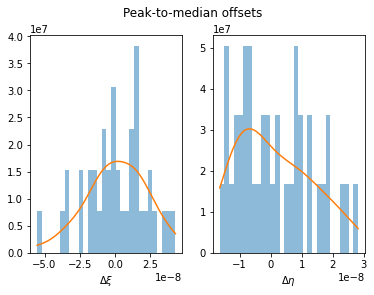

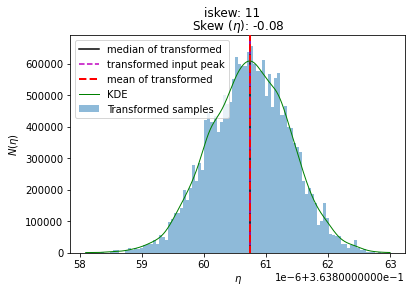

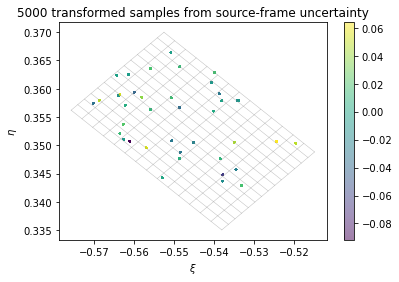

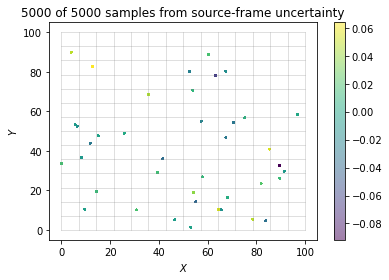

In [49]:
# Now draw samples from the projected uncertainty

# again, if we don't have the truths then the meaning of the pset is a little different.
#
# Allow this to work...

# NOTICE: if you have the truth parameters, you probably want to set pathpset=pathpset

apply2d.unctysamples(5000, \
                     pathpset=pathpguess,\
                     pathobs='eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp))

In [ ]:
showargs['corner']

In [ ]:
FS.ismain.size

In [ ]:
FS.flat_samples.shape

In [ ]:
FS.flat_samples[FS.ismain,:].shape